In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D,GlobalAveragePooling2D, GlobalMaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, SpecificityAtSensitivity
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from PIL import Image

import os

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import ImageEnhance, ImageOps, Image
from tqdm import tqdm

from torchvision import transforms
import random

## .Train data

In [3]:
train_df = pd.read_csv('C:/Users/mehmo/Downloads/train/train/train.csv')
train_df.head()

,image_id,filename,label
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,0
3,4,4.jpg,0
4,5,5.jpg,0


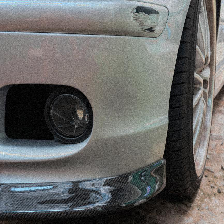

In [4]:
image.load_img("C:/Users/mehmo/Downloads/train/train/images/1.jpg", target_size=(224, 224))

In [5]:
train_df[train_df['label']==1].head()

,image_id,filename,label
17,18,18.jpg,1
62,63,63.jpg,1
100,101,101.jpg,1
117,118,118.jpg,1
139,140,140.jpg,1


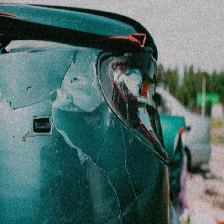

In [6]:
image.load_img("C:/Users/mehmo/Downloads/train/train/images/101.jpg", target_size=(224, 224))

In [7]:
train_df.shape

(8079, 3)

In [8]:
print(train_df['label'].dtype)

int64


In [9]:
train_df['label'] = train_df['label'].astype(str)

In [10]:
print(train_df['label'].dtype)

object


In [11]:
train_df['label'].nunique()

2

In [12]:
train_df['label'].value_counts()

label
0    7614
1     465
Name: count, dtype: int64

In [13]:
round(train_df['label'].value_counts(normalize=True) * 100,2)

label
0    94.24
1     5.76
Name: proportion, dtype: float64

## ↑↑↑↑↑  Significant class imbalance ↑↑↑↑↑


###### Need to take care of it

# Data Augmentation

In [14]:
# check point

"""

    # Read the CSV file containing image labels
    train_df = pd.read_csv('C:/Users/mehmo/Downloads/train/train/train.csv')

    # Define original and augmented directories
    original_dir = "C:/Users/mehmo/Downloads/train/train/images/"
    augmented_dir = "C:/Users/mehmo/Downloads/augmented/images/"

    # Ensure the augmented directory exists, create it if not
    if not os.path.exists(augmented_dir):
        os.makedirs(augmented_dir)

    # Function to augment images with label 1
    def augment_images(train_df):
        augmented_data = []  # List to hold augmented data
        for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
            if row['label'] == 1:
                image_filename = row['filename']
                original_image_path = os.path.join(original_dir, image_filename)

                # Load original image
                original_image = Image.open(original_image_path)

                # Data augmentation
                augmented_images = []

                # Horizontal flip
                augmented_images.append(original_image.transpose(Image.FLIP_LEFT_RIGHT))

                # Rotation (random angle between -15 and 15 degrees)
                rotation_angle = 15
                augmented_images.append(original_image.rotate(rotation_angle))
                augmented_images.append(original_image.rotate(-rotation_angle))

                # Brightness adjustment (increase and decrease brightness)
                brightness_factor = 1.5
                enhanced_brightness = ImageEnhance.Brightness(original_image).enhance(brightness_factor)
                augmented_images.append(enhanced_brightness)
                brightness_factor = 0.5
                reduced_brightness = ImageEnhance.Brightness(original_image).enhance(brightness_factor)
                augmented_images.append(reduced_brightness)

                # Random cropping
                crop_size = (100, 100)  # Random crop size
                width, height = original_image.size
                left = random.randint(0, width - crop_size[0])
                top = random.randint(0, height - crop_size[1])
                right = left + crop_size[0]
                bottom = top + crop_size[1]
                cropped_image = original_image.crop((left, top, right, bottom))
                augmented_images.append(cropped_image)

                # Random resizing
                resize_scale = random.uniform(0.8, 1.2)  # Random scale factor between 0.8 and 1.2
                resized_image = original_image.resize((int(width * resize_scale), int(height * resize_scale)))
                augmented_images.append(resized_image)

                # Random color jitter
                color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
                color_jittered_image = color_jitter(original_image)
                augmented_images.append(color_jittered_image)

                # Save augmented images
                for idx, augmented_image in enumerate(augmented_images):
                    augmented_image_filename = f"{os.path.splitext(image_filename)[0]}_augmented_{idx}.jpg"
                    augmented_image_path = os.path.join(augmented_dir, augmented_image_filename)
                    augmented_image.save(augmented_image_path)

                    # Update augmented data list with new row for augmented image
                    new_row = row.copy()
                    new_row['filename'] = augmented_image_filename
                    augmented_data.append(new_row)

        # Create DataFrame from augmented data
        augmented_train_df = pd.DataFrame(augmented_data)

        # Save updated DataFrame with augmented images
        augmented_train_df.to_csv('C:/Users/mehmo/Downloads/augmented/augmented_train.csv', index=False)

    # Call the function to perform data augmentation
    augment_images(train_df)

"""
print("checkpoint")
# Check point


checkpoint


In [15]:
from PIL import Image, ImageEnhance, ImageFilter
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter
import numpy as np
import elasticdeform

In [16]:
train_df = pd.read_csv('C:/Users/mehmo/Downloads/train/train/train.csv')
original_dir = "C:/Users/mehmo/Downloads/train/train/images/"
augmented_dir = "C:/Users/mehmo/Downloads/augmented/images/"
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
# Function to augment images with label 1
def augment_images(train_df):
    augmented_data = []  # List to hold augmented data
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        if row['label'] == 1:
            image_filename = row['filename']
            original_image_path = os.path.join(original_dir, image_filename)

            # Load original image
            original_image = Image.open(original_image_path)

            # Data augmentation
            augmented_images = []

            # Horizontal flip
            augmented_images.append(original_image.transpose(Image.FLIP_LEFT_RIGHT))

            # Rotation (random angle between -15 and 15 degrees)
            rotation_angle = 15
            augmented_images.append(original_image.rotate(rotation_angle))
            augmented_images.append(original_image.rotate(-rotation_angle))

            # Random rotation
            random_rotation_angle = random.randint(-15, 15)
            augmented_images.append(original_image.rotate(random_rotation_angle))

            # Random shear
            shear_angle = random.uniform(-0.2, 0.2)
            augmented_images.append(original_image.transform(original_image.size, Image.AFFINE, (1, shear_angle, 0, 0, 1, 0), fillcolor=(255, 255, 255)))

            # Random translation
            translation_x = random.randint(-20, 20)
            translation_y = random.randint(-20, 20)
            augmented_images.append(original_image.transform(original_image.size, Image.AFFINE, (1, 0, translation_x, 0, 1, translation_y), fillcolor=(255, 255, 255)))

            # Gaussian blur
            augmented_images.append(original_image.filter(ImageFilter.GaussianBlur(radius=2)))

            # Random noise
            noisy_image = random_noise(np.array(original_image), mode='gaussian')
            augmented_images.append(Image.fromarray((noisy_image * 255).astype(np.uint8)))

            # Random contrast
            contrast_factor = random.uniform(0.8, 1.2)
            contrast_adjusted_image = ImageEnhance.Contrast(original_image).enhance(contrast_factor)
            augmented_images.append(contrast_adjusted_image)

            # Random saturation
            saturation_factor = random.uniform(0.8, 1.2)
            saturation_adjusted_image = ImageEnhance.Color(original_image).enhance(saturation_factor)
            augmented_images.append(saturation_adjusted_image)

            # Random sharpness
            sharpness_factor = random.uniform(0.8, 1.2)
            sharpness_adjusted_image = ImageEnhance.Sharpness(original_image).enhance(sharpness_factor)
            augmented_images.append(sharpness_adjusted_image)

            # Random brightness
            brightness_factor = random.uniform(0.8, 1.2)
            brightness_adjusted_image = ImageEnhance.Brightness(original_image).enhance(brightness_factor)
            augmented_images.append(brightness_adjusted_image)

            # Random color jitter
            color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
            color_jittered_image = color_jitter(original_image)
            augmented_images.append(color_jittered_image)

            # Save augmented images
            for idx, augmented_image in enumerate(augmented_images):
                augmented_image_filename = f"{os.path.splitext(image_filename)[0]}_augmented_{idx}.jpg"
                augmented_image_path = os.path.join(augmented_dir, augmented_image_filename)
                augmented_image.save(augmented_image_path)

                # Update augmented data list with new row for augmented image
                new_row = row.copy()
                new_row['filename'] = augmented_image_filename
                augmented_data.append(new_row)

    # Create DataFrame from augmented data
    augmented_train_df = pd.DataFrame(augmented_data)

    # Save updated DataFrame with augmented images
    augmented_train_df.to_csv('C:/Users/mehmo/Downloads/augmented/augmented_train.csv', index=False)

# Call the function to perform data augmentation
augment_images(train_df)


100%|██████████████████████████████████████████████████████████████████████████████| 8079/8079 [04:49<00:00, 27.94it/s]


In [17]:
augmented_train_df = pd.read_csv('C:/Users/mehmo/Downloads/augmented/augmented_train.csv')
augmented_train_df.head(13)

,image_id,filename,label
0,18,18_augmented_0.jpg,1
1,18,18_augmented_1.jpg,1
2,18,18_augmented_2.jpg,1
3,18,18_augmented_3.jpg,1
4,18,18_augmented_4.jpg,1
5,18,18_augmented_5.jpg,1
6,18,18_augmented_6.jpg,1
7,18,18_augmented_7.jpg,1
8,18,18_augmented_8.jpg,1
9,18,18_augmented_9.jpg,1


In [18]:
augmented_train_df.shape

(6045, 3)

In [19]:
train_df[train_df['label']==1].shape

(465, 3)

In [20]:
train_df[train_df['label']==1].head()

,image_id,filename,label
17,18,18.jpg,1
62,63,63.jpg,1
100,101,101.jpg,1
117,118,118.jpg,1
139,140,140.jpg,1


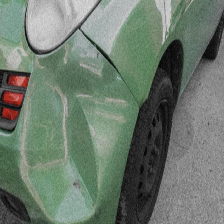

In [21]:
image.load_img("C:/Users/mehmo/Downloads/train/train/images/18.jpg", target_size=(224, 224))

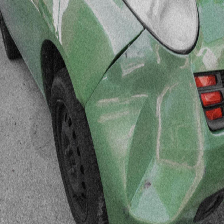

In [22]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_0.jpg", target_size=(224, 224))

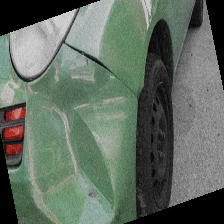

In [23]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_1.jpg", target_size=(224, 224))

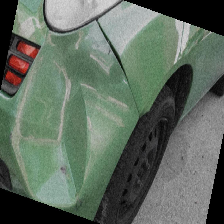

In [24]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_2.jpg", target_size=(224, 224))

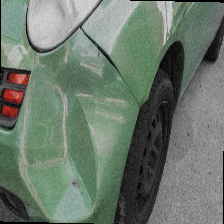

In [25]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_3.jpg", target_size=(224, 224))

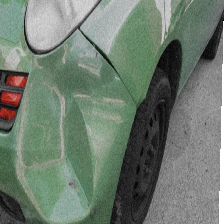

In [26]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_4.jpg", target_size=(224, 224))

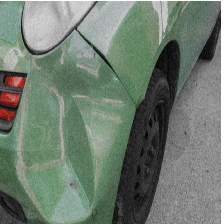

In [27]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_5.jpg", target_size=(224, 224))

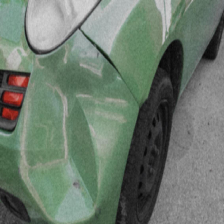

In [28]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_6.jpg", target_size=(224, 224))

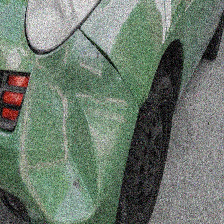

In [29]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_7.jpg", target_size=(224, 224))

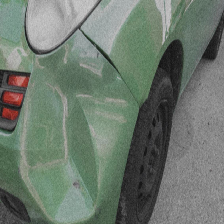

In [30]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_8.jpg", target_size=(224, 224))

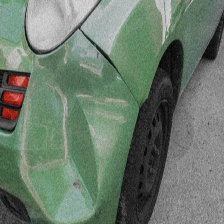

In [31]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_9.jpg", target_size=(224, 224))

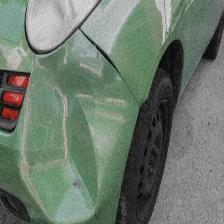

In [32]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_10.jpg", target_size=(224, 224))

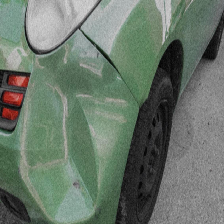

In [33]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_11.jpg", target_size=(224, 224))

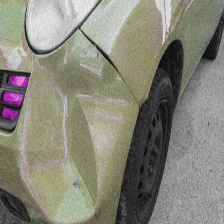

In [34]:
image.load_img("C:/Users/mehmo/Downloads/augmented/images/18_augmented_12.jpg", target_size=(224, 224))

In [35]:
train_df.shape

(8079, 3)

In [36]:
augmented_train_df.shape

(6045, 3)

In [37]:
merged_df = pd.concat([train_df, augmented_train_df], ignore_index=True)

In [38]:
merged_df.shape

(14124, 3)

In [39]:
train_df['label'].value_counts() 

label
0    7614
1     465
Name: count, dtype: int64

In [40]:
augmented_train_df['label'].value_counts() 

label
1    6045
Name: count, dtype: int64

In [41]:
6145 + 465

6610

In [42]:
merged_df['label'].value_counts() 

label
0    7614
1    6510
Name: count, dtype: int64

In [43]:
round(merged_df['label'].value_counts(normalize=True) * 100,2)

label
0    53.91
1    46.09
Name: proportion, dtype: float64

In [44]:
from shutil import copyfile

# Read the CSV file containing image labels
train_df = pd.read_csv('C:/Users/mehmo/Downloads/train/train/train.csv')

# Define original and augmented directories
original_dir = "C:/Users/mehmo/Downloads/train/train/images/"
augmented_dir = "C:/Users/mehmo/Downloads/augmented/images/"
all_images_dir = "C:/Users/mehmo/Downloads/augmented/all_images/"

# Ensure the all images directory exists, create it if not
if not os.path.exists(all_images_dir):
    os.makedirs(all_images_dir)

# Function to copy images to the all images directory
def copy_images_to_all_folder(train_df, source_dir, destination_dir):
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        image_filename = row['filename']
        source_image_path = os.path.join(source_dir, image_filename)
        destination_image_path = os.path.join(destination_dir, image_filename)
        copyfile(source_image_path, destination_image_path)

# Copy original images to all images directory
copy_images_to_all_folder(train_df, original_dir, all_images_dir)

# Copy augmented images to all images directory
augmented_train_df = pd.read_csv('C:/Users/mehmo/Downloads/augmented/augmented_train.csv')
copy_images_to_all_folder(augmented_train_df, augmented_dir, all_images_dir)

100%|█████████████████████████████████████████████████████████████████████████████| 6045/6045 [00:31<00:00, 194.55it/s]


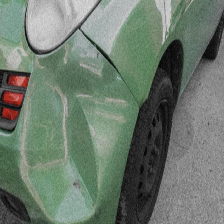

In [45]:
image.load_img("C:/Users/mehmo/Downloads/augmented/all_images/18.jpg", target_size=(224, 224))

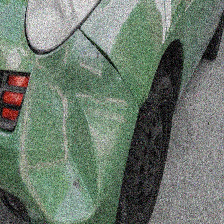

In [46]:
image.load_img("C:/Users/mehmo/Downloads/augmented/all_images/18_augmented_7.jpg", target_size=(224, 224))

In [47]:
def count_images_in_folder(folder_path):
    # Initialize a counter for images
    image_count = 0
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Iterate through each file and check if it's an image
    for file in files:
        # Get the file extension
        _, file_extension = os.path.splitext(file)
        
        # Check if the file extension corresponds to an image
        if file_extension.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
            image_count += 1
            
    return image_count

In [48]:
count_images_in_folder("C:/Users/mehmo/Downloads/augmented/all_images/")

14124

In [49]:
merged_df.shape

(14124, 3)

In [50]:
### check_point

In [51]:
merged_df.head()

,image_id,filename,label
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,0
3,4,4.jpg,0
4,5,5.jpg,0


## Data Split (Train-Validation)

### ` Stop Data Leakage`

In [52]:
merged_df_copy = merged_df.copy()

In [53]:
train_image_dir = 'C:/Users/mehmo/Downloads/augmented/all_images/'
train_image_name = merged_df_copy['filename']

In [54]:
merged_df_copy['label'] = merged_df_copy['label'].astype(str)

In [55]:
merged_df_copy.head()

,image_id,filename,label
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,0
3,4,4.jpg,0
4,5,5.jpg,0


In [56]:
merged_df_copy.shape

(14124, 3)

In [57]:
merged_df_copy['label'].value_counts()

label
0    7614
1    6510
Name: count, dtype: int64

In [58]:
merged_df_copy_0 = merged_df_copy[merged_df_copy["label"] == '0']

In [59]:
merged_df_copy_0.shape

(7614, 3)

In [60]:
merged_df_copy_1 = merged_df_copy[merged_df_copy["label"] == '1']

In [61]:
merged_df_copy_1.shape

(6510, 3)

In [62]:
train_df['label'].value_counts()

label
0    7614
1     465
Name: count, dtype: int64

##### `image_id == 1`

In [63]:
image_id_1 = merged_df_copy_1['image_id'].unique()

In [64]:
len(image_id_1)

465

In [65]:
np.random.seed(42)
val_image_id_1 = np.random.choice(image_id_1, size=46, replace=False)

In [66]:
len(val_image_id_1)

46

In [67]:
train_image_id_1 = np.setdiff1d(image_id_1, val_image_id_1)

In [68]:
len(train_image_id_1)

419

In [69]:
list(set(train_image_id_1).intersection(set(val_image_id_1)))

[]

##### `image_id == 0`

In [70]:
image_id_0 = merged_df_copy_0['image_id'].unique()

In [71]:
len(image_id_0)

7614

In [177]:
np.random.seed(42)
val_image_id_0 = np.random.choice(image_id_0, size=1748, replace=False)

In [178]:
len(val_image_id_0)

1748

In [179]:
train_image_id_0 = np.setdiff1d(image_id_0, val_image_id_0)

In [180]:
len(train_image_id_0)

5866

In [181]:
list(set(train_image_id_0).intersection(set(val_image_id_0)))

[]

##### `Merging`

In [182]:
train_ids = np.concatenate((train_image_id_0, train_image_id_1))

In [183]:
val_ids = np.concatenate((val_image_id_0, val_image_id_1))

In [184]:
len(train_ids)

6285

In [185]:
len(val_ids)

1794

##### `Splitting`

In [186]:
train_data = merged_df_copy.loc[merged_df_copy["image_id"].isin(train_ids)]

In [187]:
train_data.shape

(11732, 3)

In [188]:
train_data['label'].value_counts()

label
0    5866
1    5866
Name: count, dtype: int64

In [189]:
val_data = merged_df_copy.loc[merged_df_copy["image_id"].isin(val_ids)]

In [190]:
val_data.shape

(2392, 3)

In [191]:
val_data['label'].value_counts()

label
0    1748
1     644
Name: count, dtype: int64

In [192]:
merged_df_copy.shape

(14124, 3)

##### `Check for leakage`

In [193]:
def check_for_leakage(df1, df2, col):

    df1_unique = set(df1[col])
    df2_unique = set(df2[col])
    
    in_both_groups = list(df1_unique.intersection(df2_unique))

    leakage = len(in_both_groups) > 0 # boolean 
    
    return leakage

In [194]:
check_for_leakage(train_data, val_data, "image_id")

False

In [195]:
round(train_data['label'].value_counts(normalize=True) * 100,2)

label
0    50.0
1    50.0
Name: proportion, dtype: float64

In [196]:
round(val_data['label'].value_counts(normalize=True) * 100,2)

label
0    73.08
1    26.92
Name: proportion, dtype: float64

In [197]:
# ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [198]:
batch_size = 32



# Create the training data generators

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),  # adjust size as needed
    batch_size=batch_size,
    class_mode = 'binary',
    shuffle=True
)

Found 11732 validated image filenames belonging to 2 classes.


In [199]:
len(train_generator)

367

In [200]:
print("Shape of 1st batch processed training data:",train_generator[0][0].shape)

Shape of 1st batch processed training data: (32, 224, 224, 3)


In [206]:
367*32

11744

In [202]:
# Create the training data generators

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=train_image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 2392 validated image filenames belonging to 2 classes.


In [203]:
len(val_generator)

75

In [204]:
print("Shape of 1st batch processed validation data:",val_generator[0][0].shape)

Shape of 1st batch processed validation data: (32, 224, 224, 3)


In [205]:
75*32

2400

## . Test data

In [99]:
test_df = pd.read_csv("C:/Users/mehmo/Downloads/test/test/test.csv")
test_df.head()

,image_id,filename
0,8080,8080.jpg
1,8081,8081.jpg
2,8082,8082.jpg
3,8083,8083.jpg
4,8084,8084.jpg


In [100]:
test_df.shape

(3462, 2)

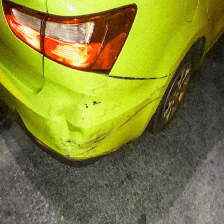

In [101]:
image.load_img("C:/Users/mehmo/Downloads/test/test/images/8080.jpg", target_size=(224, 224))

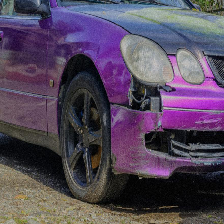

In [102]:
image.load_img("C:/Users/mehmo/Downloads/test/test/images/8081.jpg", target_size=(224, 224))

In [103]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

In [104]:
test_image_dir = 'C:/Users/mehmo/Downloads/test/test/images/'
test_image_names = test_df['filename']

In [105]:
full_path =[]
for image_name in test_image_names:
    # Construct the full file path
    path = os.path.join(test_image_dir, image_name)
    full_path.append(path)

In [106]:
full_path[:5]

['C:/Users/mehmo/Downloads/test/test/images/8080.jpg',
 'C:/Users/mehmo/Downloads/test/test/images/8081.jpg',
 'C:/Users/mehmo/Downloads/test/test/images/8082.jpg',
 'C:/Users/mehmo/Downloads/test/test/images/8083.jpg',
 'C:/Users/mehmo/Downloads/test/test/images/8084.jpg']

In [107]:
test_images = [preprocess_image(path) for path in full_path]

In [108]:
test_data = np.vstack(test_images) # Vertical stack the arrays

In [109]:
print("Shape of processed test data:", test_data.shape)

Shape of preprocessed test data: (3462, 224, 224, 3)


## .Model Building

#### `Weighted loss for imbalanced data`

In [110]:
def compute_class_freqs(labels):

    N = len(labels)
    
    positive_frequencies = np.sum(labels,axis = 0)/N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [119]:
# freq_pos, freq_neg = compute_class_freqs(train_df['label'])

In [207]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

In [208]:
pos_weights = [freq_neg]
neg_weights = [freq_pos]

In [209]:
pos_weights

[0.5]

In [210]:
neg_weights

[0.5]

In [123]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(pos_weights)):
            loss += - ((pos_weights * y_true * tf.keras.backend.log(y_pred+epsilon)) + (neg_weights * (1-y_true) * tf.keras.backend.log(1-y_pred+epsilon))) #complete this line
            loss = tf.keras.backend.mean(loss)
        return loss
    return weighted_loss

## Model 1

In [217]:
from tensorflow.keras.applications import DenseNet121

In [218]:
base_model = base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224,3))


# Unfreeze some of the layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=base_model.input, outputs=predictions)
model1.compile(optimizer=Adam(learning_rate=0.001), loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy', Precision(), Recall()])

In [152]:
history = model1.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps=5, 
                              epochs = 5)

Epoch 1/5
100/100 [==============================] - 363s 4s/step - loss: 0.0897 - accuracy: 0.9294 - precision_4: 0.9219 - recall_4: 0.9244 - val_loss: 0.1733 - val_accuracy: 0.8438 - val_precision_4: 0.2667 - val_recall_4: 0.7273
Epoch 2/5
100/100 [==============================] - 362s 4s/step - loss: 0.0860 - accuracy: 0.9331 - precision_4: 0.9254 - recall_4: 0.9280 - val_loss: 0.1349 - val_accuracy: 0.8875 - val_precision_4: 0.3333 - val_recall_4: 0.6364
Epoch 3/5
100/100 [==============================] - 363s 4s/step - loss: 0.0833 - accuracy: 0.9328 - precision_4: 0.9219 - recall_4: 0.9326 - val_loss: 0.4386 - val_accuracy: 0.9312 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/5
100/100 [==============================] - 362s 4s/step - loss: 0.0740 - accuracy: 0.9397 - precision_4: 0.9303 - recall_4: 0.9368 - val_loss: 0.0630 - val_accuracy: 0.9500 - val_precision_4: 0.6667 - val_recall_4: 0.5455
Epoch 5/5
100/100 [==============================] - 363s 4s/ste

In [153]:
predictions_val = model1.predict(val_generator)

44/44 [==============================] - 53s 1s/step


In [154]:
predictions_val[:5]

array([[0.187538  ],
       [0.00310131],
       [0.11568305],
       [0.00035348],
       [0.01635534]], dtype=float32)

In [155]:
len(predictions_val)

1405

In [156]:
val_data.shape

(1405, 3)

In [157]:
val_data.head()

,image_id,filename,label
17,18,18.jpg,1
20,21,21.jpg,0
24,25,25.jpg,0
32,33,33.jpg,0
38,39,39.jpg,0


In [158]:
val_data['label'] = val_data['label'].astype(int)

In [159]:
from sklearn.metrics import f1_score

# Adjust the threshold based on your needs
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    binary_predictions = (predictions_val > threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(val_data['label'], binary_predictions)
    print(f"F1 score at threshold {threshold}: {f1}")


F1 score at threshold 0.0: 0.628599316739873
F1 score at threshold 0.1: 0.9097688292319165
F1 score at threshold 0.2: 0.8939873417721519
F1 score at threshold 0.3: 0.8774509803921569
F1 score at threshold 0.4: 0.8676716917922948
F1 score at threshold 0.5: 0.8418323249783924
F1 score at threshold 0.6: 0.8135593220338984
F1 score at threshold 0.7: 0.7716682199440821
F1 score at threshold 0.8: 0.7480916030534351
F1 score at threshold 0.9: 0.7177974434611604
F1 score at threshold 0.95: 0.6761710794297353
F1 score at threshold 1.0: 0.0


In [160]:
confusion_matrix(val_data['label'], (predictions_val > .95).astype(int) )

array([[755,   6],
       [312, 332]], dtype=int64)

In [161]:
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensi', 'speci', 'f1_score_value'])

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
for threshold in thresholds:
    cm1 = confusion_matrix(val_data['label'], (predictions_val > threshold).astype(int))
    total1 = sum(sum(cm1))
    accuracy = (cm1[0, 0] + cm1[1, 1]) / total1
    
    speci = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    sensi = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    f1_score_value = f1_score(val_data['label'], (predictions_val > threshold).astype(int))
    cutoff_df.loc[threshold] = [threshold, accuracy, sensi, speci, f1_score_value]

print(cutoff_df)


      prob  accuracy     sensi     speci  f1_score_value
0.00  0.00  0.458363  1.000000  0.000000        0.628599
0.10  0.10  0.913879  0.947205  0.885677        0.909769
0.20  0.20  0.904626  0.877329  0.927727        0.893987
0.30  0.30  0.893238  0.833851  0.943495        0.877451
0.40  0.40  0.887544  0.804348  0.957950        0.867672
0.50  0.50  0.869751  0.756211  0.965834        0.841832
0.60  0.60  0.851246  0.708075  0.972405        0.813559
0.70  0.70  0.825623  0.642857  0.980289        0.771668
0.80  0.80  0.812100  0.608696  0.984231        0.748092
0.90  0.90  0.795730  0.566770  0.989488        0.717797
0.95  0.95  0.773665  0.515528  0.992116        0.676171
1.00  1.00  0.541637  0.000000  1.000000        0.000000


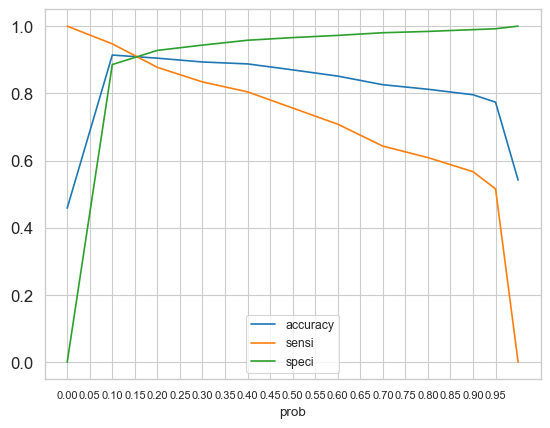

In [162]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
sns.set_style('whitegrid')
sns.set_context('paper')
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0, 1, step = 0.05), size=8)
plt.yticks(size=12)
plt.show()

In [163]:
predictions_test = model1.predict(test_data)

109/109 [==============================] - 119s 1s/step


In [167]:
predictions_test[:10].round(2)

array([[0.  ],
       [0.  ],
       [0.01],
       [0.02],
       [0.98],
       [0.12],
       [0.02],
       [0.07],
       [0.01],
       [0.01]], dtype=float32)

In [ ]:
predictions_test_labels = (predictions_test > .2).astype(int)

In [ ]:
predictions_test_labels[:5]

In [ ]:
predictions_test_labels.flatten()

In [ ]:
test_file_names = test_df['image_id']

In [ ]:
test_file_names.head()

In [ ]:
# Create a DataFrame with file names and predicted labels
results_df = pd.DataFrame({'image_id': test_file_names, 'label': predictions_test_labels.flatten()})

results_df.head()

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('C:/Users/mehmo/Downloads/sub.csv', index=False)